In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
# from problems.ising_problem2 import IsingProblem2
from problems.ising_problem import IsingProblem
from problems.ising_problem3 import IsingProblem3
from problems.toy_problem import ToyProblem
from problems.baby_problem import BabyProblem1
from problems.baby_problem2 import UFProblem
from problems.benchmark_problem import BenchmarkProblem
from qiskit.providers.fake_provider import *
from bin.cost_function import cost_loc, calc_err, cost_global, local_hadamard_test, hadamard_overlap_test
from bin.hyperparameters import *
from bin.error_mitigation import mitigate_node

import time

In [2]:
# # Import the library that you need in order to use your IBM account
# from qiskit_ibm_provider import IBMProvider
# from secrets import *


# try:
#     IBMProvider()
# except:
#     IBMProvider.save_account(token=IBM_token, overwrite=True)

In [3]:
# provider = IBMProvider()
# provider.backends()

In [4]:
def configured_backend():
    # backend = provider.get_backend("ibm_osaka") # uncomment this line to use a real IBM device
    backend = FakeManila()
    # backend.options.update_options(...)
    return backend

In [5]:
# # define the problem we want to perform our experiment on
# n_qubits = 5
# error = 0.01
# cond_num = 50

# problem = ToyProblem(
#     n_qubits=n_qubits,
# )

In [6]:
n_qubits = 2
cond_num = 10
error = 0.1
# error = 1.6 * 10**-3

# problem = BenchmarkProblem(n_qubits)
# problem = ToyProblem(n_qubits)
problem = IsingProblem(n_qubits,J=0.1, cond_num=cond_num)

['XI', 'IX', 'ZZ', 'II']


In [7]:
# initialize weights
w = q_delta * np.random.randn(problem.param_shape,requires_grad=True)
w1 = w.copy()
# w = q_delta * np.random.randn(2, requires_grad=True)
init_weights = list(w.numpy())
# w = q_delta * np.random.randn(batch_size, problem.param_shape, requires_grad=True)

In [8]:
# create our devices to run our circuits on
dev_mu = qml.device("default.qubit", wires=n_qubits+1)
# dev_mu = qml.device("default.qubit", wires=n_qubits+3)
dev_gamma = qml.device("default.qubit", wires=n_qubits*2 + 1)
# dev_mu = qml.device("qiskit.remote", wires=n_qubits+1, backend=configured_backend()) # device for real IBM devices noisy simulators

In [9]:
# in order to make the error mitigation work, we have to pull out the QNode definition outside of the cost function so I'm doing it here
local_hadamard_test = qml.QNode(local_hadamard_test, dev_mu, interface="autograd")
# local_hadamard_test = mitigate_node(local_hadamard_test)

In [10]:
# overlap test is used for the global cost function
hadamard_overlap_test = qml.QNode(hadamard_overlap_test, dev_gamma, interface="autograd")
# hadamard_overlap_test = mitigate_node(hadamard_overlap_test)

In [11]:
# w1s_nonML = []
# w2s_nonML = []
cost_history2 = []

def cost_fun(w):
    cost = cost_loc(problem, w, local_hadamard_test)
    cost_history2.append(cost)
    # w1s_nonML.append(w[0])
    # w2s_nonML.append(w[1])

    return cost

In [12]:
# # use non-ML optimization methods
from scipy.optimize import minimize
if OPTIMIZER == "COBYLA":
    start = time.time()
    res = minimize(cost_fun,
                    w1,
                    method='COBYLA',
                    tol=error
                    )
    TTS = time.time() - start

    w1 = res.x
    calc_err(n_qubits, cost_history2[-1], cond_num)



In [13]:
print(qml.draw(local_hadamard_test, expansion_strategy="device")(w, problem, l=0, lp=0, j=-1, part="Im"))

0: ──RY(-1.34)─╭●──────────RY(-2.02)─╭●──RY(0.10)─╭X──H──H─╭X────┤     
1: ──RY(-2.25)─╰Z──────────RY(-1.61)─╰Z──RY(0.30)─│───H──H─│─────┤     
2: ──H──────────Rϕ(-1.57)─────────────────────────╰●───────╰●──H─┤  <Z>


In [14]:
from IPython.display import clear_output

# opt = qml.GradientDescentOptimizer(eta)
opt = qml.GradientDescentOptimizer(0.3)
# opt = qml.AdagradOptimizer(eta)
# opt = qml.AdamOptimizer(eta) # TODO: tune decay terms

cost_history = []

err = float("inf")
it = 1

In [33]:
cost_loc(problem, w, local_hadamard_test)

tensor(0.03062369, requires_grad=True)

In [16]:
if OPTIMIZER == f"SGD_lr={eta}":
    # training loop

    best_err = 1000
    best_w = w
    # prev_w = w

    w1s = []
    w2s = []

    start = time.time()
    while err > error and it < 1000:
    # for it in range(300):
        w, cost = opt.step_and_cost(lambda w: cost_loc(problem, w, local_hadamard_test), w)
        # w, cost = opt.step_and_cost(lambda w: cost_global(problem, w, local_hadamard_test, hadamard_overlap_test), w)

        w1s.append(w[0])
        w2s.append(w[1])

        err = calc_err(n_qubits, cost, cond_num)
        if err < best_err:
            best_err = err
            best_w = w
        
        clear_output(wait=True)

        # print(np.array_equal(best_w, w))

        print("Step {:3d}       Cost_L = {:9.7f} \t error = {:9.7f}".format(it, cost, err), flush=True)
        cost_history.append(cost)

        prev_w = w

        it += 1

    TTS = time.time() - start
    STS = it

    print(f"Training time: {TTS}s")

In [17]:
# best_err

### Optimization studies:
- each epoch is taking ~ 20s
- Each $\mu$ calculation takes ~0.05s but occasionally spikes to ~0.3s
- Each $\mu_{sum}$ has to loop over each combination of A_l for each qubit -> $c^2n$ operations -> ~15s
- Each $|\psi|$ also has to loop over each combination, but we're unable to recycle computation because these don't apply $CZ$ like the above -> ~4s
- The ising problem has 8 C's
    - Note that `len(c) = n_qubits * 2` by definition of H_ising
- 8 * 8 * 4 * 2 = ~512 mu accumulations

--> $8n^3 + 4n^2$ iterations

It should be possible to multithread the calculation, but not sure if that's feasible when testing on an actual QC


* n_qubits = 5: 1100 mu accumulations
* n_qubits = 6: 1872 mu accumulations
* n_qubits = 7: 2940 mu accumulations

/var/folders/46/x_y_zr5s2rj1v37fwfjmjh9r0000gn/T/ipykernel_87442/1603760836.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


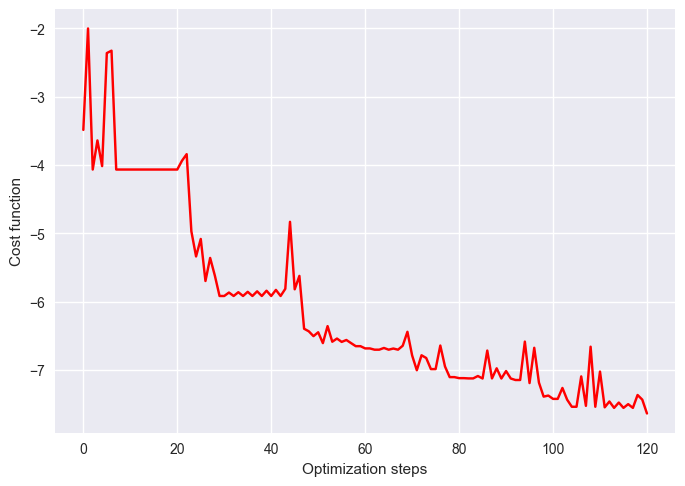

In [34]:
plt.style.use("seaborn")
# plt.plot(np.log(cost_history), "g")
plt.plot(np.log(cost_history2), "r")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

In [19]:
# xs = np.linspace(-np.pi, np.pi, 50)
# ys = np.linspace(-np.pi, np.pi, 50)

# costs = []

# for x in xs:
#     row = []
#     for y in ys:
#         row.append(cost_loc(problem, [x,y], local_hadamard_test))
#     costs.append(row)

# costs = np.array(costs)

In [20]:
# w1s_norm = ((np.array(w1s) % (np.pi) + np.pi) / (2 * np.pi)) * 50
# w2s_norm = ((np.array(w2s) % (np.pi) + np.pi) / (2 * np.pi)) * 50

In [21]:
# w1s_nonML_norm = (((np.array(w1s_nonML) + np.pi) % (2 * np.pi)) / (2 * np.pi)) * 50
# w2s_nonML_norm = (((np.array(w2s_nonML) + np.pi) % (2 * np.pi)) / (2 * np.pi)) * 50
# w1s_nonML_norm

In [22]:
# plt.plot(w1s_norm, w2s_norm, color='red')

In [23]:
# plt.plot(w1s_nonML_norm, w2s_nonML_norm, color='red')

In [24]:
# import seaborn as sns

# num_boxes = 50
# # rescale weights
# # w1s_norm = ((np.array(w1s) % (np.pi) + np.pi) / (2 * np.pi)) * 50
# # w2s_norm = ((np.array(w2s) % (np.pi) + np.pi) / (2 * np.pi)) * 50

# num_ticks = 10
# # the index of the position of yticks
# yticks = np.linspace(0,num_boxes,num_ticks)
# # the content of labels of these yticks
# yticklabels = np.round(np.linspace(-np.pi, np.pi, num_ticks),2)
# # the index of the position of xticks
# xticks = np.linspace(0,num_boxes,num_ticks)
# # the content of labels of these xticks
# xticklabels = np.round(np.linspace(-np.pi, np.pi, num_ticks),2)

# sns.heatmap(costs, yticklabels=yticklabels)
# plt.yticks(yticks, yticklabels)
# plt.xticks(xticks, xticklabels)

# # Plot scatterplot on top
# # plt.plot(w2s_norm, w1s_norm, color='blue')
# plt.plot(w2s_nonML_norm, w1s_nonML_norm, color='green')
# plt.show()

In [25]:
# init_weights

Qualitatively, it's converging slower than the toy problem, suggesting more iterations are needed

In [35]:
from bin.inference import get_cprobs, get_qprobs
c_probs = get_cprobs(problem)

# dev_x = qml.device("qiskit.remote", wires=n_qubits, backend=configured_backend())
dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

def prepare_and_sample(problem, weights):

    # Variational circuit generating a guess for the solution vector |x>
    problem.variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

def get_qprobs(problem, w, device):
    sampler = qml.QNode(prepare_and_sample, device)

    # sampler = mitigate_node(sampler)

    raw_samples = sampler(problem, w)
    # raw_samples = np.concatenate(raw_samples, axis=0)# FOR BATCHING

    print(raw_samples[:min(len(raw_samples), 10)])

    # convert the raw samples (bit strings) into integers and count them
    samples = []
    for sam in raw_samples:
        samples.append(int("".join(str(bs) for bs in sam), base=2))

    # q_probs = np.bincount(raw_samples, minlength=2**problem.n_qubits) / len(raw_samples)
    q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / len(raw_samples)
    # q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / n_shots

    return q_probs

In [36]:
if OPTIMIZER != "COBYLA":
    q_probs = get_qprobs(problem, w, dev_x)
else:
    q_probs = get_qprobs(problem, w1, dev_x)

[[0 1]
 [0 0]
 [1 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 0]
 [1 0]
 [1 1]]


In [37]:
q_probs = get_qprobs(problem, w1, dev_x)

[[1 1]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


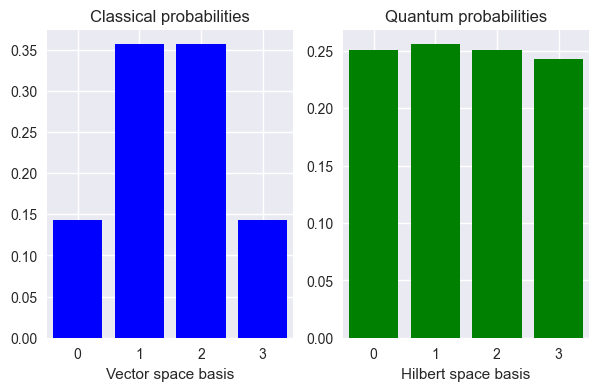

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

In [30]:
result = {
    "problem": str(problem),
    "n_qubits": n_qubits,
    "ansatz": f"{problem.n_layers}-layer HEA",
    "cost": "local",
    "optimizer": OPTIMIZER,
    "cond_num": cond_num,
    "error_threshold": error,
    "noise_model": NOISE_MODEL,
    "TTS": TTS,
    "STS": len(cost_history2) if OPTIMIZER == "COBYLA" else len(cost_history),
    "cost_history": list(cost_history) if OPTIMIZER != "COBYLA" else [tensor.item() for tensor in cost_history2],
    "model_weights": list(w1) if OPTIMIZER == "COBYLA" else list(w.numpy()),
    "init_weights": init_weights
}

In [31]:
result

{'problem': '<problems.ising_problem.IsingProblem object at 0x13e05b9d0>',
 'n_qubits': 2,
 'ansatz': '2-layer HEA',
 'cost': 'local',
 'optimizer': 'COBYLA',
 'cond_num': 10,
 'error_threshold': 0.1,
 'noise_model': None,
 'TTS': 93.93813014030457,
 'STS': 121,
 'cost_history': [0.030623688301175844,
  0.13521191830696477,
  0.017141283919414996,
  0.026256443260089246,
  0.018021891332109408,
  0.09429048763331849,
  0.0976817575941823,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.017141283919414996,
  0.019497283174145785,
  0.021473796920628396,
  0.006939347376479721,
  0.004802877776352632,
  0.006204317045688024,
  0.0033528978791790842,
  0.004698166027649442,
  0.0036272812752295436,
  0.0026919758629925794,
  

In [32]:
# # serialize to JSON?
# import json

# with open('data/Ising.json', 'a') as fp:
#     fp.write(",")
#     json.dump(result, fp)